## Training script for the CNN 

Loads in the converted plane representation of the pgn files, defines the network architecture and starts the training process. Checkpoints of the weights are saved if there's an improvement in the validation loss.
The training performance metrics (e.g. losses, accuracies...) are exported to tensorboard and can be checked during training.
* author: QueensGambit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:

from __future__ import print_function
import os
import sys
sys.path.insert(0,'../../../')
import glob
import chess
import shutil
import logging
import numpy as np
from mxnet import nd
from copy import deepcopy
import mxnet as mx
from mxnet import gluon
try:
    import mxnet.metric as metric
except ModuleNotFoundError:
    import mxnet.gluon.metric as metrics

from DeepCrazyhouse.src.domain.variants.input_representation import board_to_planes, planes_to_board
from DeepCrazyhouse.src.domain.variants.output_representation import policy_to_moves, policy_to_best_move, policy_to_move
from DeepCrazyhouse.src.preprocessing.dataset_loader import load_pgn_dataset
from DeepCrazyhouse.src.runtime.color_logger import enable_color_logging
from DeepCrazyhouse.src.domain.neural_net.architectures.a0_resnet import AlphaZeroResnet
from DeepCrazyhouse.src.domain.neural_net.architectures.mxnet_alpha_zero import alpha_zero_symbol
from DeepCrazyhouse.src.domain.neural_net.architectures.rise_mobile_v2 import rise_mobile_v2_symbol
from DeepCrazyhouse.src.domain.neural_net.architectures.rise_mobile_v3 import rise_mobile_v3_symbol
from DeepCrazyhouse.configs.main_config import main_config
from DeepCrazyhouse.configs.train_config import TrainConfig, TrainObjects
from DeepCrazyhouse.src.training.trainer_agent import TrainerAgent, evaluate_metrics, acc_sign
from DeepCrazyhouse.src.training.trainer_agent_mxnet import TrainerAgentMXNET, get_context, prepare_policy
from DeepCrazyhouse.src.training.lr_schedules.lr_schedules import *
from DeepCrazyhouse.src.domain.variants.plane_policy_representation import FLAT_PLANE_IDX
from DeepCrazyhouse.src.domain.variants.constants import NB_POLICY_MAP_CHANNELS, NB_LABELS
from DeepCrazyhouse.src.domain.neural_net.onnx.convert_to_onnx import convert_mxnet_model_to_onnx

enable_color_logging()
%matplotlib inline

2021-02-16 01:39:06 matplotlib.pyplot[18908] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Settings

In [4]:
tc = TrainConfig()
to = TrainObjects()

In [5]:
# set the context on CPU, switch to GPU if there is one available (strongly recommended for training)
tc.context = "gpu"
tc.device_id = 0

# set a specific seed value for reproducibility
tc.seed = 7 # 42

tc.export_weights = True
tc.log_metrics_to_tensorboard = True
tc.export_grad_histograms = True

# directory to write and read weights, logs, onnx and other export files
tc.export_dir = "./"

tc.div_factor = 1  # div factor is a constant which can be used to reduce the batch size and learning rate respectively
# use a value greater 1 if you encounter memory allocation errors


# batch_steps = 1000 means for example that every 1000 batches the validation set gets processed
tc.batch_steps = 1000 * tc.div_factor # this defines how often a new checkpoint will be saved and the metrics evaluated
# k_steps_initial defines how many steps have been trained before
# (k_steps_initial != 0 if you continue training from a checkpoint)
tc.k_steps_initial = 0
# these are the weights to continue training with
tc.symbol_file = None # 'model-0.81901-0.713-symbol.json'
tc.params_file = None #'model-0.81901-0.713-0498.params'

tc.batch_size = int(1024 / tc.div_factor) # 1024 # the batch_size needed to be reduced to 1024 in order to fit in the GPU 1080Ti
#4096 was originally used in the paper -> works slower for current GPU
# 2048 was used in the paper Mastering the game of Go without human knowledge and fits in GPU memory
#typically if you half the batch_size, you should double the lr

# optimization parameters
tc.optimizer_name = "nag"
tc.max_lr = 0.35 / tc.div_factor #0.01 # default lr for adam
tc.min_lr = 0.00001
tc.max_momentum = 0.95
tc.min_momentum = 0.8
# loads a previous checkpoint if the loss increased significanly
tc.use_spike_recovery = True
# stop training as soon as max_spikes has been reached
tc.max_spikes = 20
# define spike threshold when the detection will be triggered
tc.spike_thresh = 1.5
# weight decay
tc.wd = 1e-4
tc.dropout_rate = 0 #0.15
# weight the value loss a lot lower than the policy loss in order to prevent overfitting
tc.val_loss_factor = 0.01
tc.policy_loss_factor = 0.99
tc.discount = 1.0

tc.normalize = True # define whether to normalize input data to [0,1]
tc.nb_epochs = 4 # define how many epochs the network will be trained
tc.select_policy_from_plane = True # Boolean if potential legal moves will be selected from final policy output
tc.use_mxnet_style = False  # Decide between mxnet and gluon style for training

# additional custom validation set files which will be logged to tensorboard
to.variant_metrics = None # ["chess960", "koth", "three_check"]
# if use_extra_variant_input is true the current active variant is passed two each residual block and

# ratio for mixing the value return with the corresponding q-value
# for a ratio of 0 no q-value information will be used
tc.q_value_ratio = 0
        
# define if policy training target is one-hot encoded a distribution (e.g. mcts samples, knowledge distillation)
tc.sparse_policy_label = False
# define if the policy data is also defined in "select_policy_from_plane" representation
tc.is_policy_from_plane_data = True
tc.name_initials = "DS"

In [6]:
mode = main_config["mode"]
ctx = get_context(tc.context, tc.device_id)
# concatenated at the end of the final feature representation
use_extra_variant_input = False
cur_it = tc.k_steps_initial * tc.batch_steps # iteration counter used for the momentum and learning rate schedule
# Fixing the random seed
mx.random.seed(tc.seed)

In [7]:
mx.__version__

'1.7.0'

### Create logs and weights directory

In [8]:
if not os.path.exists(tc.export_dir + "logs"):
    os.mkdir(tc.export_dir + "logs")
if not os.path.exists(tc.export_dir + "weights"):
    os.mkdir(tc.export_dir + "weights")

Ein Unterverzeichnis oder eine Datei mit dem Namen "logs" existiert bereits.


### Show the config files

In [9]:
print(main_config)

{'pgn_train_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/train/', 'pgn_val_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/val/', 'pgn_test_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/test/', 'pgn_mate_in_one_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/mate_in_one/', 'planes_train_dir': 'E:\\KD_DATA', 'planes_val_dir': 'C:\\Users\\Daniel\\Desktop\\UNI\\BSC Thesis\\Train_data\\planes\\val\\2018-09-27-12-36-37', 'planes_test_dir': 'C:\\Users\\Daniel\\Desktop\\UNI\\BSC Thesis\\Train_data\\planes\\test\\2018-09-27-12-37-07', 'planes_mate_in_one_dir': 'C:\\Users\\Daniel\\Desktop\\UNI\\BSC Thesis\\Train_data\\planes\\mate_in_one\\2018-09-27-12-37-30', 'rec_dir': 'E:\\rec_dir', 'model_architecture_dir': 'E:\\NN_KD\\symbol', 'model_weights_dir': 'E:\\NN_KD\\params', 'value_output': 'value_out', 'policy_output': 'policy_out', 'mode': 0, 'version': 1}


In [10]:
print(tc)

TrainConfig(train_on_soft_labels=True, soft_value_name='y_value_prediction_risev2_27', soft_policy_name='y_policy_prediction_risev2_27', hard_label_weight=0.25, div_factor=1, batch_size=1024, batch_steps=1000, context='gpu', cpu_count=0, cwd=None, device_id=0, discount=1.0, dropout_rate=0, export_weights=True, export_grad_histograms=True, is_policy_from_plane_data=True, log_metrics_to_tensorboard=True, k_steps_initial=0, symbol_file=None, params_file=None, optimizer_name='nag', max_lr=0.35, min_lr=1e-05, max_momentum=0.95, min_momentum=0.8, max_spikes=20, name_initials='DS', nb_parts=None, normalize=True, nb_epochs=4, policy_loss_factor=0.99, q_value_ratio=0, seed=7, select_policy_from_plane=True, spike_thresh=1.5, sparse_policy_label=False, total_it=None, use_spike_recovery=True, val_loss_factor=0.01, wd=0.0001)


In [11]:
print(to)

TrainObjects()


### Load the dataset-files

### Validation Dataset (which is used during training)

In [12]:
s_idcs_val, x_val, yv_val, yp_val, plys_to_end, pgn_datasets_val = load_pgn_dataset(dataset_type='val', part_id=0,
                                                                           verbose=True, normalize=tc.normalize)
if tc.discount != 1:
    yv_val *= tc.discount**plys_to_end

if tc.use_mxnet_style:
    if tc.select_policy_from_plane:
        val_iter = mx.io.NDArrayIter({'data': x_val}, {'value_label': yv_val, 'policy_label': np.array(FLAT_PLANE_IDX)[yp_val.argmax(axis=1)]}, tc.batch_size)
    else:
        val_iter = mx.io.NDArrayIter({'data': x_val}, {'value_label': yv_val, 'policy_label': yp_val.argmax(axis=1)}, tc.batch_size)
else:
    val_dataset = gluon.data.ArrayDataset(nd.array(x_val), nd.array(yv_val), nd.array(prepare_policy(yp_val, tc.select_policy_from_plane, tc.sparse_policy_label, tc.is_policy_from_plane_data)))
    val_data = gluon.data.DataLoader(val_dataset, tc.batch_size, shuffle=False, num_workers=tc.cpu_count)

2021-02-16 01:39:07 root[18908] DEBUG loading: C:\Users\Daniel\Desktop\UNI\BSC Thesis\Train_data\planes\val\2018-09-27-12-36-37\lichess_db_crazyhouse_rated_2018-04_0.zip...
2021-02-16 01:39:07 root[18908] DEBUG 
2021-02-16 01:39:07 root[18908] INFO STATISTICS:
black_wins [443]
draws [3]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [554]
2021-02-16 01:39:07 root[18908] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'lichess_db_crazyhouse_rated_2018-04.pgn']
termination_conditions [b'Normal']


In [13]:
tc.nb_parts = len(glob.glob(main_config['planes_train_dir'] + '**/*'))
tc.nb_parts

554

In [14]:
nb_it_per_epoch = (len(x_val) * tc.nb_parts) // tc.batch_size # calculate how many iterations per epoch exist
# one iteration is defined by passing 1 batch and doing backprop
tc.total_it = int(nb_it_per_epoch * tc.nb_epochs)
tc.total_it

124168

### Define a Learning Rate schedule

2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'DejaVu Sans Displ

2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal 700 normal>) = 10.335
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal 290 normal>) = 10.1545
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal

2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Consolas' (consolab.ttf) normal normal 700 normal>) = 10.335
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal 350 normal>) = 10.0975
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
202

2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal 700 normal>) = 10.335
2021-02-16 01:39:08 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal 700 normal>) = 10.335
2021-02-16 01:39:09 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:09 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:09 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Cambria' (cambriaz.ttf) italic normal 700 normal>) = 11.335
2021-02-16 01:39:09 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
2021-02-16 01:39:09 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Marlett' (marlett.ttf) normal normal 500 normal>) = 10.145
2

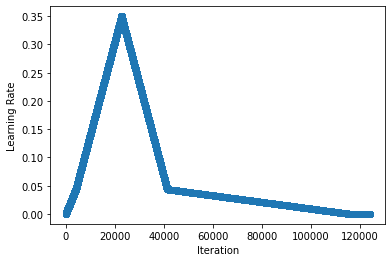

In [15]:
to.lr_schedule = OneCycleSchedule(start_lr=tc.max_lr/8, max_lr=tc.max_lr, cycle_length=tc.total_it*.3, cooldown_length=tc.total_it*.6, finish_lr=tc.min_lr)
to.lr_schedule = LinearWarmUp(to.lr_schedule, start_lr=tc.min_lr, length=tc.total_it/30)

logging.getLogger().setLevel(logging.WARNING)
plot_schedule(to.lr_schedule, iterations=tc.total_it)
logging.getLogger().setLevel(logging.DEBUG)

### Momentum schedule

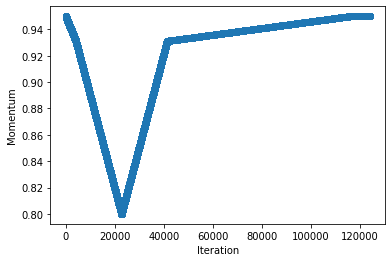

In [16]:
to.momentum_schedule = MomentumSchedule(to.lr_schedule, tc.min_lr, tc.max_lr, tc.min_momentum, tc.max_momentum)
plot_schedule(to.momentum_schedule, iterations=tc.total_it, ylabel='Momentum')

### Create the model

In [17]:
input_shape = x_val[0].shape
input_shape

(34, 8, 8)

In [18]:
try:
    del net
except:
    pass

### Define the NN model / Load the pretrained model

In [19]:
symbol = None

In [20]:
#net = AlphaZeroResnet(n_labels=2272, channels=256, channels_value_head=8, channels_policy_head=81, num_res_blocks=19, value_fc_size=256, bn_mom=0.9, act_type='relu', select_policy_from_plane=select_policy_from_plane)

In [21]:
#net = alpha_zero_resnet(n_labels=2272, channels=256, channels_value_head=1, channels_policy_head=81, num_res_blocks=19, value_fc_size=256, bn_mom=0.9, act_type='relu')

In [22]:
#symbol = alpha_zero_symbol(num_filter=256, channels_value_head=4, channels_policy_head=81, workspace=1024, value_fc_size=256, num_res_blocks=19, bn_mom=0.9, act_type='relu',
#                            n_labels=2272, grad_scale_value=0.01, grad_scale_policy=0.99, select_policy_from_plane=select_policy_from_plane)

In [23]:
bc_res_blocks = [3] * 4
if tc.symbol_file is None:
    symbol = rise_mobile_v2_symbol(channels=128, channels_operating_init=128, channel_expansion=64, channels_value_head=8,
                      channels_policy_head=NB_POLICY_MAP_CHANNELS, value_fc_size=256, bc_res_blocks=bc_res_blocks, res_blocks=[], act_type='relu',
                      n_labels=NB_LABELS, grad_scale_value=tc.val_loss_factor, grad_scale_policy=tc.policy_loss_factor, select_policy_from_plane=tc.select_policy_from_plane,
                      use_se=True, dropout_rate=tc.dropout_rate, use_extra_variant_input=use_extra_variant_input)
else:
    symbol = mx.sym.load(tc.export_dir + "weights/" + tc.symbol_file)

kernels = [
    [3],  # 0
    [3],  # 1
    [3],  # 2
    [3],  # 3
    [3],  # 4
    [3],  # 5
    [3],  # 6
    [3],  # 7
    [3],  # 8
    [5],  # 9
    [5],  # 10
    [5],  # 11
    [3],  # 12
]
se_types = [
    None, # 0
    None, # 1
    "ca_se",  # 2
    "sa_se",  # 3
    None, # 4
    None, # 5
    None, # 6
    None, # 7
    "cm_se", # 8
    "sm_se",  # 9
    "ca_se",  # 10
    "sa_se",  # 11
    None, # 12
]
symbol = rise_mobile_v3_symbol(channels=256, channels_operating_init=512, channel_expansion=0, act_type='relu',
                               channels_value_head=8, value_fc_size=256,
                               channels_policy_head=NB_POLICY_MAP_CHANNELS,
                               grad_scale_value=tc.val_loss_factor, grad_scale_policy=tc.policy_loss_factor, 
                               dropout_rate=tc.dropout_rate, select_policy_from_plane=True,
                               kernels=kernels, se_ratio=4, se_types=se_types)

### Convert MXNet Symbol to Gluon Network

In [24]:
if not tc.use_mxnet_style and symbol is not None:
    inputs = mx.sym.var('data', dtype='float32')
    value_out = symbol.get_internals()[main_config['value_output']+'_output']
    policy_out = symbol.get_internals()[main_config['policy_output']+'_output']
    sym = mx.symbol.Group([value_out, policy_out])
    net = mx.gluon.SymbolBlock(sym, inputs)

## Network summary

In [25]:
if not tc.use_mxnet_style:
    print(net)

SymbolBlock(
<Symbol group [value_out, policy_out]> : 1 -> 2
)


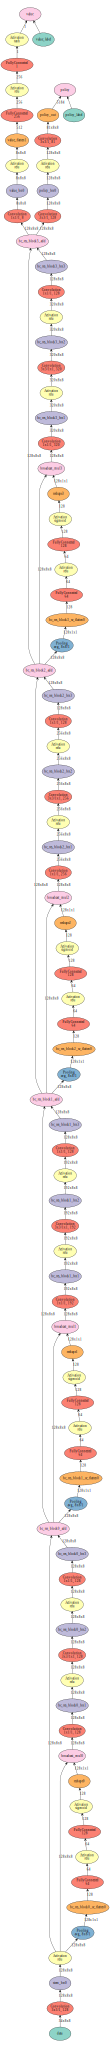

In [26]:
if symbol is not None:
    display(mx.viz.plot_network(
        symbol,
        shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
        node_attrs={"shape":"oval","fixedsize":"false"}
    ))
else:
    display(mx.viz.plot_network(
        net(mx.sym.var('data'))[1],
        shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
        node_attrs={"shape":"oval","fixedsize":"false"}
    ))

In [27]:
if tc.use_mxnet_style:
    mx.viz.print_summary(
        symbol,
        shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
    )
else:
    mx.viz.print_summary(
    net(mx.sym.var('data'))[1], 
    shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
    ) 

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          34x8x8                  0                                           
________________________________________________________________________________________________________________________
stem_conv0(Convolution)                             128x8x8                 39168       data                            
________________________________________________________________________________________________________________________
stem_bn0(BatchNorm)                                 128x8x8                 256         stem_conv0                      
________________________________________________________________________________________________________________________
stem_act0(Activation)           

## Initialize the weights 
(only needed if no pretrained weights are used)

In [28]:
# create a trainable module on compute context
if tc.use_mxnet_style:
    model = mx.mod.Module(symbol=symbol, context=ctx, label_names=['value_label', 'policy_label'])
    model.bind(for_training=True, data_shapes=[('data', (tc.batch_size, input_shape[0], input_shape[1], input_shape[2]))],
             label_shapes=val_iter.provide_label)
    model.init_params(mx.initializer.Xavier(rnd_type='uniform', factor_type='avg', magnitude=2.24))
    if tc.params_file:
        model.load_params(tc.export_dir + "weights/" + tc.params_file)
else:    
    # Initializing the parameters
    for param in net.collect_params('.*gamma|.*moving_mean|.*moving_var'):
        net.params[param].initialize(mx.initializer.Constant(1), ctx=ctx)
    for param in net.collect_params('.*beta|.*bias'):
        net.params[param].initialize(mx.initializer.Constant(0), ctx=ctx)
    for param in net.collect_params('.*weight'):
        net.params[param].initialize(mx.init.Xavier(rnd_type='uniform', factor_type='avg', magnitude=2.24), ctx=ctx)

    if tc.params_file:
        net.collect_params().load(tc.export_dir + "weights/" + tc.params_file, ctx)
    net.hybridize()

## Define the metrics to use

In [29]:
metrics_mxnet = [
metric.MSE(name='value_loss', output_names=['value_output'], label_names=['value_label']),
metric.CrossEntropy(name='policy_loss', output_names=['policy_output'],
                                            label_names=['policy_label']),
metric.create(acc_sign, name='value_acc_sign', output_names=['value_output'],
                                         label_names=['value_label']),
metric.Accuracy(axis=1, name='policy_acc', output_names=['policy_output'],
                                       label_names=['policy_label'])
]
metrics_gluon = {
'value_loss': metric.MSE(name='value_loss', output_names=['value_output']),
'policy_loss': metric.CrossEntropy(name='policy_loss', output_names=['policy_output'],
                                            label_names=['policy_label']),
'value_acc_sign': metric.create(acc_sign, name='value_acc_sign', output_names=['value_output'],
                                         label_names=['value_label']),
'policy_acc': metric.Accuracy(axis=1, name='policy_acc', output_names=['policy_output'],
                                       label_names=['policy_label'])
}
if tc.use_mxnet_style:
    to.metrics = metrics_mxnet
else:
    to.metrics = metrics_gluon

## Define a training agent

In [30]:
if tc.use_mxnet_style:
    train_agent = TrainerAgentMXNET(model, symbol, val_iter, tc, to)
else:
    train_agent = TrainerAgent(net, val_data, tc, to)

## Performance Pre-Training

In [31]:
if tc.use_mxnet_style:
    print(model.score(val_iter, to.metrics))

## Start the training process

In [32]:
(k_steps_final, value_loss_final, policy_loss_final, value_acc_sign_final, val_p_acc_final), (k_steps_best, val_loss_best, val_p_acc_best) = train_agent.train(cur_it)

2021-02-16 01:39:11 root[18908] INFO EPOCH 1
2021-02-16 01:39:11 root[18908] INFO =========================


  0%|          | 0/554 [00:00<?, ?it/s]

2021-02-16 01:43:24 root[18908] INFO Step 1K/124K - 253ms/step
2021-02-16 01:43:24 root[18908] INFO -------------------------
2021-02-16 01:43:24 root[18908] DEBUG Iteration 1000/124168
2021-02-16 01:43:24 root[18908] DEBUG lr: 0.0105674 - momentum: 0.9454753
 - train_loss: 1.7139 - train_value_loss: 0.2678 - train_policy_loss: 1.7286 - train_value_acc_sign: 0.6563 - train_policy_acc: 0.5299 - val_loss: 2.2113 - val_value_loss: 0.9929 - val_policy_loss: 2.2236 - val_value_acc_sign: 0.5678 - val_policy_acc: 0.4098
2021-02-16 01:43:41 root[18908] INFO Saved checkpoint to ./weights/model-2.21126-0.410-0001.params
 - 270s
2021-02-16 01:47:43 root[18908] INFO Step 2K/124K - 241ms/step
2021-02-16 01:47:43 root[18908] INFO -------------------------
2021-02-16 01:47:43 root[18908] DEBUG Iteration 2000/124168
2021-02-16 01:47:43 root[18908] DEBUG lr: 0.0211353 - momentum: 0.9409460
 - train_loss: 1.5155 - train_value_loss: 0.2044 - train_policy_loss: 1.5287 - train_value_acc_sign: 0.6681 - trai

2021-02-16 02:38:32 root[18908] INFO Step 14K/124K - 237ms/step
2021-02-16 02:38:32 root[18908] INFO -------------------------
2021-02-16 02:38:32 root[18908] DEBUG Iteration 14000/124168
2021-02-16 02:38:32 root[18908] DEBUG lr: 0.2058769 - momentum: 0.8617688
 - train_loss: 0.9624 - train_value_loss: 0.0742 - train_policy_loss: 0.9713 - train_value_acc_sign: 0.8308 - train_policy_acc: 0.7121 - val_loss: 1.5175 - val_value_loss: 0.8125 - val_policy_loss: 1.5247 - val_value_acc_sign: 0.6641 - val_policy_acc: 0.5231
2021-02-16 02:38:47 root[18908] INFO Saved checkpoint to ./weights/model-1.51755-0.523-0014.params
 - 252s
2021-02-16 02:42:41 root[18908] INFO Step 15K/124K - 234ms/step
2021-02-16 02:42:41 root[18908] INFO -------------------------
2021-02-16 02:42:41 root[18908] DEBUG Iteration 15000/124168
2021-02-16 02:42:41 root[18908] DEBUG lr: 0.2223196 - momentum: 0.8547217
 - train_loss: 0.9224 - train_value_loss: 0.0643 - train_policy_loss: 0.9311 - train_value_acc_sign: 0.8462 - 

2021-02-16 03:36:29 root[18908] INFO Step 28K/124K - 230ms/step
2021-02-16 03:36:29 root[18908] INFO -------------------------
2021-02-16 03:36:29 root[18908] DEBUG Iteration 28000/124168
2021-02-16 03:36:29 root[18908] DEBUG lr: 0.2639243 - momentum: 0.8368907
 - train_loss: 0.8701 - train_value_loss: 0.0521 - train_policy_loss: 0.8784 - train_value_acc_sign: 0.8550 - train_policy_acc: 0.7460 - val_loss: 1.4503 - val_value_loss: 0.7926 - val_policy_loss: 1.4570 - val_value_acc_sign: 0.6749 - val_policy_acc: 0.5385
2021-02-16 03:36:45 root[18908] INFO Saved checkpoint to ./weights/model-1.45034-0.538-0028.params
 - 245s
2021-02-16 03:40:39 root[18908] INFO Step 29K/124K - 234ms/step
2021-02-16 03:40:39 root[18908] INFO -------------------------
2021-02-16 03:40:39 root[18908] DEBUG Iteration 29000/124168
2021-02-16 03:40:39 root[18908] DEBUG lr: 0.2474815 - momentum: 0.8439378
 - train_loss: 0.8497 - train_value_loss: 0.0536 - train_policy_loss: 0.8578 - train_value_acc_sign: 0.8542 - 

  0%|          | 0/554 [00:00<?, ?it/s]

2021-02-16 03:48:55 root[18908] INFO Step 31K/124K - 137ms/step
2021-02-16 03:48:55 root[18908] INFO -------------------------
2021-02-16 03:48:55 root[18908] DEBUG Iteration 31000/124168
2021-02-16 03:48:55 root[18908] DEBUG lr: 0.2145959 - momentum: 0.8580320
 - train_loss: 0.8584 - train_value_loss: 0.0534 - train_policy_loss: 0.8666 - train_value_acc_sign: 0.8437 - train_policy_acc: 0.7452 - val_loss: 1.4467 - val_value_loss: 0.7949 - val_policy_loss: 1.4533 - val_value_acc_sign: 0.6706 - val_policy_acc: 0.5367 - 152s
2021-02-16 03:53:07 root[18908] INFO Step 32K/124K - 237ms/step
2021-02-16 03:53:07 root[18908] INFO -------------------------
2021-02-16 03:53:07 root[18908] DEBUG Iteration 32000/124168
2021-02-16 03:53:07 root[18908] DEBUG lr: 0.1981532 - momentum: 0.8650791
 - train_loss: 0.8656 - train_value_loss: 0.0536 - train_policy_loss: 0.8738 - train_value_acc_sign: 0.8565 - train_policy_acc: 0.7526 - val_loss: 1.4283 - val_value_loss: 0.7924 - val_policy_loss: 1.4348 - val

 - 242s
2021-02-16 04:46:17 root[18908] INFO Step 45K/124K - 232ms/step
2021-02-16 04:46:17 root[18908] INFO -------------------------
2021-02-16 04:46:17 root[18908] DEBUG Iteration 45000/124168
2021-02-16 04:46:17 root[18908] DEBUG lr: 0.0416307 - momentum: 0.9321620
 - train_loss: 0.8174 - train_value_loss: 0.0494 - train_policy_loss: 0.8252 - train_value_acc_sign: 0.8661 - train_policy_acc: 0.7708 - val_loss: 1.3884 - val_value_loss: 0.7862 - val_policy_loss: 1.3945 - val_value_acc_sign: 0.6776 - val_policy_acc: 0.5541
2021-02-16 04:46:32 root[18908] INFO Saved checkpoint to ./weights/model-1.38837-0.554-0045.params
 - 247s
2021-02-16 04:50:25 root[18908] INFO Step 46K/124K - 233ms/step
2021-02-16 04:50:25 root[18908] INFO -------------------------
2021-02-16 04:50:25 root[18908] DEBUG Iteration 46000/124168
2021-02-16 04:50:25 root[18908] DEBUG lr: 0.0410436 - momentum: 0.9324137
 - train_loss: 0.8691 - train_value_loss: 0.0615 - train_policy_loss: 0.8772 - train_value_acc_sign: 0

2021-02-16 05:39:33 root[18908] DEBUG lr: 0.0339983 - momentum: 0.9354332
 - train_loss: 0.7526 - train_value_loss: 0.0419 - train_policy_loss: 0.7598 - train_value_acc_sign: 0.8704 - train_policy_acc: 0.8146 - val_loss: 1.3581 - val_value_loss: 0.7825 - val_policy_loss: 1.3639 - val_value_acc_sign: 0.6781 - val_policy_acc: 0.5635
2021-02-16 05:39:48 root[18908] INFO Saved checkpoint to ./weights/model-1.35807-0.563-0058.params
 - 242s
2021-02-16 05:43:41 root[18908] INFO Step 59K/124K - 232ms/step
2021-02-16 05:43:41 root[18908] INFO -------------------------
2021-02-16 05:43:41 root[18908] DEBUG Iteration 59000/124168
2021-02-16 05:43:41 root[18908] DEBUG lr: 0.0334112 - momentum: 0.9356848
 - train_loss: 0.8248 - train_value_loss: 0.0510 - train_policy_loss: 0.8327 - train_value_acc_sign: 0.8283 - train_policy_acc: 0.7880 - val_loss: 1.3615 - val_value_loss: 0.7878 - val_policy_loss: 1.3673 - val_value_acc_sign: 0.6743 - val_policy_acc: 0.5638 - 247s
2021-02-16 05:47:47 root[18908] 

  0%|          | 0/554 [00:00<?, ?it/s]

2021-02-16 05:51:55 root[18908] INFO Step 61K/124K - 43ms/step
2021-02-16 05:51:55 root[18908] INFO -------------------------
2021-02-16 05:51:55 root[18908] DEBUG Iteration 61000/124168
2021-02-16 05:51:55 root[18908] DEBUG lr: 0.0322370 - momentum: 0.9361880
 - train_loss: 1.0925 - train_value_loss: 0.0946 - train_policy_loss: 1.1026 - train_value_acc_sign: 0.7898 - train_policy_acc: 0.6763 - val_loss: 1.6065 - val_value_loss: 0.8347 - val_policy_loss: 1.6143 - val_value_acc_sign: 0.6524 - val_policy_acc: 0.5120 - 58s
2021-02-16 05:55:57 root[18908] INFO Step 62K/124K - 227ms/step
2021-02-16 05:55:57 root[18908] INFO -------------------------
2021-02-16 05:55:57 root[18908] DEBUG Iteration 62000/124168
2021-02-16 05:55:57 root[18908] DEBUG lr: 0.0316499 - momentum: 0.9364397
 - train_loss: 0.8036 - train_value_loss: 0.0487 - train_policy_loss: 0.8113 - train_value_acc_sign: 0.8708 - train_policy_acc: 0.7939 - val_loss: 1.3850 - val_value_loss: 0.7866 - val_policy_loss: 1.3911 - val_v

2021-02-16 06:49:20 root[18908] INFO -------------------------
2021-02-16 06:49:20 root[18908] DEBUG Iteration 75000/124168
2021-02-16 06:49:20 root[18908] DEBUG lr: 0.0240175 - momentum: 0.9397108
 - train_loss: 0.9215 - train_value_loss: 0.0754 - train_policy_loss: 0.9301 - train_value_acc_sign: 0.8219 - train_policy_acc: 0.7367 - val_loss: 1.4661 - val_value_loss: 0.8133 - val_policy_loss: 1.4727 - val_value_acc_sign: 0.6647 - val_policy_acc: 0.5390 - 248s
2021-02-16 06:53:23 root[18908] INFO Step 76K/124K - 227ms/step
2021-02-16 06:53:23 root[18908] INFO -------------------------
2021-02-16 06:53:23 root[18908] DEBUG Iteration 76000/124168
2021-02-16 06:53:23 root[18908] DEBUG lr: 0.0234304 - momentum: 0.9399624
 - train_loss: 0.7683 - train_value_loss: 0.0441 - train_policy_loss: 0.7756 - train_value_acc_sign: 0.8714 - train_policy_acc: 0.8114 - val_loss: 1.3521 - val_value_loss: 0.7866 - val_policy_loss: 1.3578 - val_value_acc_sign: 0.6776 - val_policy_acc: 0.5630 - 242s
2021-02-

2021-02-16 07:46:40 root[18908] INFO Step 89K/124K - 232ms/step
2021-02-16 07:46:40 root[18908] INFO -------------------------
2021-02-16 07:46:40 root[18908] DEBUG Iteration 89000/124168
2021-02-16 07:46:40 root[18908] DEBUG lr: 0.0157980 - momentum: 0.9432335
 - train_loss: 0.7540 - train_value_loss: 0.0398 - train_policy_loss: 0.7613 - train_value_acc_sign: 0.8716 - train_policy_acc: 0.8226 - val_loss: 1.3295 - val_value_loss: 0.7776 - val_policy_loss: 1.3351 - val_value_acc_sign: 0.6817 - val_policy_acc: 0.5694
2021-02-16 07:46:55 root[18908] INFO Saved checkpoint to ./weights/model-1.32948-0.569-0089.params
 - 247s
2021-02-16 07:50:45 root[18908] INFO Step 90K/124K - 229ms/step
2021-02-16 07:50:45 root[18908] INFO -------------------------
2021-02-16 07:50:45 root[18908] DEBUG Iteration 90000/124168
2021-02-16 07:50:45 root[18908] DEBUG lr: 0.0152109 - momentum: 0.9434851
 - train_loss: 0.7440 - train_value_loss: 0.0395 - train_policy_loss: 0.7511 - train_value_acc_sign: 0.8817 - 

  0%|          | 0/554 [00:00<?, ?it/s]

2021-02-16 07:58:58 root[18908] INFO Step 92K/124K - 177ms/step
2021-02-16 07:58:58 root[18908] INFO -------------------------
2021-02-16 07:58:58 root[18908] DEBUG Iteration 92000/124168
2021-02-16 07:58:58 root[18908] DEBUG lr: 0.0140367 - momentum: 0.9439884
 - train_loss: 0.7598 - train_value_loss: 0.0371 - train_policy_loss: 0.7671 - train_value_acc_sign: 0.8841 - train_policy_acc: 0.8111 - val_loss: 1.3289 - val_value_loss: 0.7759 - val_policy_loss: 1.3345 - val_value_acc_sign: 0.6825 - val_policy_acc: 0.5699
2021-02-16 07:59:13 root[18908] INFO Saved checkpoint to ./weights/model-1.32893-0.570-0092.params
 - 192s
2021-02-16 08:03:02 root[18908] INFO Step 93K/124K - 229ms/step
2021-02-16 08:03:02 root[18908] INFO -------------------------
2021-02-16 08:03:02 root[18908] DEBUG Iteration 93000/124168
2021-02-16 08:03:02 root[18908] DEBUG lr: 0.0134496 - momentum: 0.9442400
 - train_loss: 0.7428 - train_value_loss: 0.0375 - train_policy_loss: 0.7500 - train_value_acc_sign: 0.8821 - 

2021-02-16 08:56:20 root[18908] DEBUG Iteration 106000/124168
2021-02-16 08:56:20 root[18908] DEBUG lr: 0.0058172 - momentum: 0.9475111
 - train_loss: 0.7608 - train_value_loss: 0.0418 - train_policy_loss: 0.7680 - train_value_acc_sign: 0.8755 - train_policy_acc: 0.8149 - val_loss: 1.3296 - val_value_loss: 0.7801 - val_policy_loss: 1.3352 - val_value_acc_sign: 0.6823 - val_policy_acc: 0.5695 - 246s
2021-02-16 09:00:25 root[18908] INFO Step 107K/124K - 229ms/step
2021-02-16 09:00:25 root[18908] INFO -------------------------
2021-02-16 09:00:25 root[18908] DEBUG Iteration 107000/124168
2021-02-16 09:00:25 root[18908] DEBUG lr: 0.0052301 - momentum: 0.9477628
 - train_loss: 0.7613 - train_value_loss: 0.0419 - train_policy_loss: 0.7685 - train_value_acc_sign: 0.8762 - train_policy_acc: 0.8176 - val_loss: 1.3266 - val_value_loss: 0.7804 - val_policy_loss: 1.3321 - val_value_acc_sign: 0.6808 - val_policy_acc: 0.5690 - 244s
2021-02-16 09:04:30 root[18908] INFO Step 108K/124K - 229ms/step
202

2021-02-16 09:49:39 root[18908] INFO -------------------------
2021-02-16 09:49:39 root[18908] DEBUG Iteration 119000/124168
2021-02-16 09:49:39 root[18908] DEBUG lr: 0.0000100 - momentum: 0.9500000
 - train_loss: 0.7513 - train_value_loss: 0.0377 - train_policy_loss: 0.7585 - train_value_acc_sign: 0.8851 - train_policy_acc: 0.8211 - val_loss: 1.3081 - val_value_loss: 0.7784 - val_policy_loss: 1.3134 - val_value_acc_sign: 0.6821 - val_policy_acc: 0.5751
2021-02-16 09:49:54 root[18908] INFO Saved checkpoint to ./weights/model-1.30806-0.575-0119.params
 - 247s
2021-02-16 09:53:41 root[18908] INFO Step 120K/124K - 226ms/step
2021-02-16 09:53:41 root[18908] INFO -------------------------
2021-02-16 09:53:41 root[18908] DEBUG Iteration 120000/124168
2021-02-16 09:53:41 root[18908] DEBUG lr: 0.0000100 - momentum: 0.9500000
 - train_loss: 0.7557 - train_value_loss: 0.0376 - train_policy_loss: 0.7630 - train_value_acc_sign: 0.8815 - train_policy_acc: 0.8232 - val_loss: 1.3080 - val_value_loss:

  0%|          | 0/554 [00:00<?, ?it/s]

2021-02-16 10:01:56 root[18908] INFO Step 122K/124K - 82ms/step
2021-02-16 10:01:56 root[18908] INFO -------------------------
2021-02-16 10:01:56 root[18908] DEBUG Iteration 122000/124168
2021-02-16 10:01:56 root[18908] DEBUG lr: 0.0000100 - momentum: 0.9500000
 - train_loss: 0.7550 - train_value_loss: 0.0392 - train_policy_loss: 0.7622 - train_value_acc_sign: 0.8873 - train_policy_acc: 0.8235 - val_loss: 1.3077 - val_value_loss: 0.7785 - val_policy_loss: 1.3130 - val_value_acc_sign: 0.6824 - val_policy_acc: 0.5743
2021-02-16 10:02:11 root[18908] INFO Saved checkpoint to ./weights/model-1.30767-0.574-0122.params
 - 97s
2021-02-16 10:06:00 root[18908] INFO Step 123K/124K - 229ms/step
2021-02-16 10:06:00 root[18908] INFO -------------------------
2021-02-16 10:06:00 root[18908] DEBUG Iteration 123000/124168
2021-02-16 10:06:00 root[18908] DEBUG lr: 0.0000100 - momentum: 0.9500000
 - train_loss: 0.7564 - train_value_loss: 0.0385 - train_policy_loss: 0.7636 - train_value_acc_sign: 0.8850 

## Export the last model state

In [33]:
prefix = tc.export_dir + "weights/model-%.5f-%.3f" % (policy_loss_final, val_p_acc_final)

if tc.use_mxnet_style:
    # the export function saves both the architecture and the weights
    model.save_checkpoint(prefix, epoch=k_steps_final)
else:
    # the export function saves both the architecture and the weights
    net.export(prefix, epoch=k_steps_final)
    logging.info("Saved checkpoint to %s-%04d.params", prefix, k_steps_final)

2021-02-16 10:14:30 root[18908] INFO Saved checkpoint to ./weights/model-1.31280-0.575-0125.params


## Load the best model once again

In [34]:
# delete the current net object form memory
if not tc.use_mxnet_style:
    del net
    del model

NameError: name 'model' is not defined

In [35]:
model_name = "model-%.5f-%.3f" % (val_loss_best, val_p_acc_best)
model_prefix = tc.export_dir + "weights/" + model_name
model_arch_path = '%s-symbol.json' % model_prefix
model_params_path = '%s-%04d.params' % (model_prefix, k_steps_best)
print('load current best model:', model_params_path)

symbol = mx.sym.load(model_arch_path)
inputs = mx.sym.var('data', dtype='float32')
value_out = symbol.get_internals()[main_config['value_output']+'_output']
policy_out = symbol.get_internals()[main_config['policy_output']+'_output']
sym = mx.symbol.Group([value_out, policy_out])
net = mx.gluon.SymbolBlock(sym, inputs)
net.collect_params().load(model_params_path, ctx)

load current best model: weights/model-1.30746-0.575-0125.params


In [36]:
print('best val_loss: %.5f with v_policy_acc: %.5f at k_steps_best %d' % (val_loss_best, val_p_acc_best, k_steps_best))

best val_loss: 1.30746 with v_policy_acc: 0.57526 at k_steps_best 125


## Copy best model & convert to onnx

In [37]:
if not os.path.exists(tc.export_dir + "best-model"):
    os.mkdir(tc.export_dir + "best-model")
    
best_model_prefix = tc.export_dir + "best-model/" + model_name
best_model_arch_path = '%s-symbol.json' % best_model_prefix
best_model_params_path = '%s-%04d.params' % (best_model_prefix, k_steps_best)

shutil.copy(model_arch_path, best_model_arch_path)
shutil.copy(model_params_path, best_model_params_path)

convert_mxnet_model_to_onnx(best_model_arch_path, best_model_params_path, 
                            ["value_out_output", "policy_out_output"], 
                            tuple(input_shape), tuple([1, 8, 16]), True)

In [ ]:
print("Saved json, weight & onnx files of the best model to %s" % (tc.export_dir + "best-model"))

## Show move predictions

In [ ]:
idx = 0

white
[CrazyhousePocket(''), CrazyhousePocket('')]


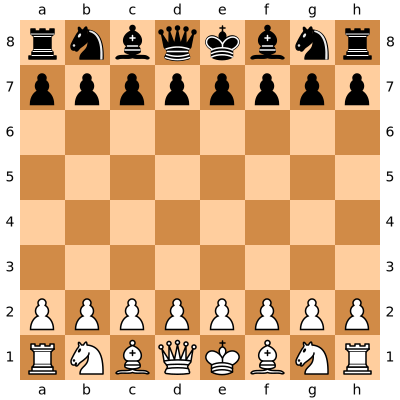

In [38]:
board = planes_to_board(x_val[idx], normalized_input=tc.normalize, mode=mode)

print(chess.COLOR_NAMES[board.turn])
if board.uci_variant == "crazyhouse":
    print(board.pockets)
board

In [39]:
def predict_single(net, x, select_policy_from_plane=False):
    
    out = [None, None]
    pred = net(mx.nd.array(np.expand_dims(x, axis=0), ctx=ctx))
    if select_policy_from_plane:
        pred[1] = pred[1][:, FLAT_PLANE_IDX]
    pred[1] = pred[1].softmax()
    out[0] = pred[0].asnumpy()
    out[1] = pred[1].asnumpy()
    
    return out

In [40]:
pred = predict_single(net, x_val[0], tc.select_policy_from_plane)
pred

[array([[0.09818296]], dtype=float32),
 array([[5.4175725e-08, 3.9658644e-08, 3.2675366e-08, ..., 4.2512696e-07,
         6.4004769e-07, 3.7207118e-07]], dtype=float32)]

In [41]:
pred = predict_single(net, x_val[0], tc.select_policy_from_plane)

In [42]:
policy_to_best_move(board, yp_val[idx])

(Move.from_uci('e2e4'), 1.0)

In [43]:
opts = 5
selected_moves, probs = policy_to_moves(board, pred[1][0])
selected_moves[:opts]

[Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('g1f3'),
 Move.from_uci('b2b3'),
 Move.from_uci('b1c3')]

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (20).

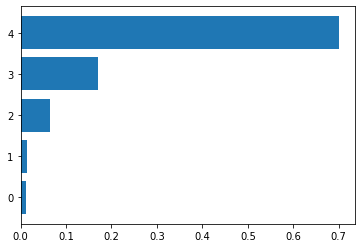

In [44]:
plt.barh(range(opts)[::-1], probs[:opts])
ax = plt.gca()
ax.set_yticks(range(opts)[::-1])
ax.set_yticklabels(selected_moves[:opts])

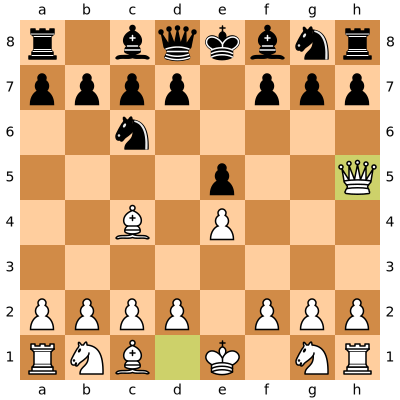

In [45]:
board = planes_to_board(x_val[0], normalized_input=True, mode=mode)
board.push_uci('e2e4')
board.push_uci('e7e5')
board.push_uci('f1c4')
board.push_uci('b8c6')
board.push_uci('d1h5')
x_scholar_atck = board_to_planes(board, normalize=tc.normalize, mode=mode)
board

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (28).

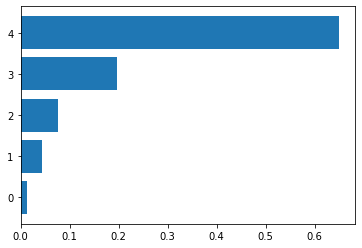

In [46]:
pred = predict_single(net, x_scholar_atck, tc.select_policy_from_plane)

selected_moves, probs = policy_to_moves(board, pred[1][0])
plt.barh(range(opts)[::-1], probs[:opts])
ax = plt.gca()
ax.set_yticks(range(opts)[::-1])
ax.set_yticklabels(selected_moves[:opts])

In [ ]:
board.push(selected_moves[0])
board

### Performance on test dataset


In [47]:
s_idcs_test, x_test, yv_test, yp_test, _, pgn_datasets_test = load_pgn_dataset(dataset_type='test', part_id=0,
                                                                               verbose=True, normalize=True)
test_dataset = gluon.data.ArrayDataset(nd.array(x_test), nd.array(yv_test), nd.array(yp_test.argmax(axis=1)))
test_data = gluon.data.DataLoader(test_dataset, batch_size=tc.batch_size, shuffle=True, num_workers=tc.cpu_count)

2021-02-16 13:01:51 root[18908] DEBUG loading: C:\Users\Daniel\Desktop\UNI\BSC Thesis\Train_data\planes\test\2018-09-27-12-37-07\lichess_db_crazyhouse_rated_2018-08_0.zip...
2021-02-16 13:01:51 root[18908] DEBUG 
2021-02-16 13:01:51 root[18908] INFO STATISTICS:
black_wins [442]
draws [5]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [553]
2021-02-16 13:01:51 root[18908] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'lichess_db_crazyhouse_rated_2018-08.pgn']
termination_conditions [b'Normal']


In [48]:
metrics = metrics_gluon
evaluate_metrics(metrics, test_data, net, nb_batches=None, sparse_policy_label=True, ctx=ctx,
                 apply_select_policy_from_plane=tc.select_policy_from_plane)

{'loss': 1.3417309584133459,
 'value_loss': 0.7667205780744553,
 'policy_loss': 1.3475391440733346,
 'value_acc_sign': 0.6903523631980664,
 'policy_acc': 0.5710432931156849}

### Show result on mate-in-one problems

In [49]:
s_idcs_mate, x_mate, yv_mate, yp_mate, _, pgn_dataset_mate = load_pgn_dataset(dataset_type='mate_in_one', part_id=0,
                                                                              verbose=True, normalize=tc.normalize)

2021-02-16 13:02:05 root[18908] DEBUG loading: C:\Users\Daniel\Desktop\UNI\BSC Thesis\Train_data\planes\mate_in_one\2018-09-27-12-37-30\lichess_db_crazyhouse_rated_2018-04_0.zip...
2021-02-16 13:02:05 root[18908] DEBUG 
2021-02-16 13:02:05 root[18908] INFO STATISTICS:
black_wins [429]
draws [0]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [571]
2021-02-16 13:02:05 root[18908] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'lichess_db_crazyhouse_rated_2018-04.pgn']
termination_conditions [b'Normal']


In [50]:
mate_dataset = mx.gluon.data.dataset.ArrayDataset(nd.array(x_mate), nd.array(yv_mate), nd.array(yp_mate.argmax(axis=1)))
mate_data = mx.gluon.data.DataLoader(mate_dataset, batch_size=tc.batch_size, num_workers=tc.cpu_count)

### Mate In One Performance

In [51]:
metrics = metrics_gluon
evaluate_metrics(metrics, mate_data, net, sparse_policy_label=True, ctx=ctx,
                 apply_select_policy_from_plane=tc.select_policy_from_plane)

{'loss': 0.7490773286628724,
 'value_loss': 0.14945149421691895,
 'policy_loss': 0.7551341552734375,
 'value_acc_sign': 0.957,
 'policy_acc': 0.749}

### Show some example mate problems

In [52]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Evaluate Performance

In [53]:
def eval_pos(net, x_mate, yp_mate, verbose=False, select_policy_from_plane=False):
    
    board = planes_to_board(x_mate, normalized_input=tc.normalize, mode=mode)
    if verbose is True:
        print("{0}'s turn".format(chess.COLOR_NAMES[board.turn]))
        if board.uci_variant == "crazyhouse":
            print("black/white {0}".format(board.pockets))
    pred = predict_single(net, x_mate, select_policy_from_plane=select_policy_from_plane)
    
    true_move = policy_to_move(yp_mate, is_white_to_move=board.turn)
    
    opts = 5
    pred_moves, probs = policy_to_moves(board, pred[1][0])
    pred_moves = pred_moves[:opts]
    
    legal_move_cnt = board.legal_moves.count()
    mate_move_cnt = str(board.legal_moves).count('#')
    
    is_mate_5_top = False
    
    for pred_move in pred_moves:
        board_5_top = deepcopy(board)
        board_5_top.push(pred_move)
        if board_5_top.is_checkmate() is True:
            is_mate_5_top = True
            break
    
    board.push(pred_moves[0])
    
    is_checkmate = False
    if board.is_checkmate() is True:
        is_checkmate = True
        
    filtered_pred = sorted(pred[1][0], reverse=True)
    
    if verbose is True:
        plt.barh(range(opts)[::-1], filtered_pred[:opts])
        ax = plt.gca()
        ax.set_yticks(range(opts)[::-1])
        ax.set_yticklabels(pred_moves)
        plt.title('True Move:' + str(true_move) +
                 '\nEval:' + str(pred[0][0]))
        plt.show()
    
    return pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt

In [54]:
nb_pos = len(x_mate)
mates_found = []
mates_5_top_found = []
legal_mv_cnts = []
mate_mv_cnts = []

for i in range(nb_pos):
    pred, pred_moves, true_move, board, is_mate, is_mate_5_top, legal_mv_cnt, mate_mv_cnt= eval_pos(net, x_mate[i], yp_mate[i], select_policy_from_plane=tc.select_policy_from_plane)
    mates_found.append(is_mate)
    legal_mv_cnts.append(legal_mv_cnt)
    mate_mv_cnts.append(mate_mv_cnt)
    mates_5_top_found.append(is_mate_5_top)

In [55]:
np.array(mate_mv_cnts).mean()

1.623

In [56]:
np.array(legal_mv_cnts).mean()

115.817

### Random Guessing Baseline

In [57]:
np.array(mate_mv_cnts).mean() / np.array(legal_mv_cnts).mean()

0.014013486793821289

### Prediciton Performance

In [58]:
print('mate_in_one_acc:', sum(mates_found) / nb_pos)

mate_in_one_acc: 0.88


In [59]:
sum(mates_5_top_found) / nb_pos

0.989

In [60]:
pgn_dataset_mate.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='metadata (1001, 17) |…

In [61]:
metadata = np.array(pgn_dataset_mate['metadata'])
metadata[0, :]
metadata[1, :]

array([b'Event', b'Site', b'Date', b'Round', b'White', b'Black',
       b'Result', b'BlackElo', b'BlackRatingDiff', b'BlackTitle',
       b'Termination', b'TimeControl', b'UTCDate', b'UTCTime', b'Variant',
       b'WhiteElo', b'WhiteRatingDiff'], dtype='|S128')

array([b'Rated Crazyhouse tournament https://lichess.org/tournament/EkplkgHV',
       b'https://lichess.org/6XtZaN95', b'2018.03.31', b'-', b'mrsjadk26',
       b'beatles_21', b'1-0', b'2101', b'-11', b'FM', b'Normal', b'180+0',
       b'2018.03.31', b'22:00:44', b'Crazyhouse', b'2158', b'+11'],
      dtype='|S128')

In [62]:
site_mate = metadata[1:, 1]

In [63]:
def clean_string(np_string):
    string = str(site_mate[i]).replace("b'", "")
    string = string.replace("'", "")
    string = string.replace('"', '')
    
    return string

In [64]:
import chess.svg
from IPython.display import SVG, HTML

## Show the result of the first 17 examples

https://lichess.org/6XtZaN95
white's turn
black/white [CrazyhousePocket('qbnp'), CrazyhousePocket('rn')]
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) =

2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal 700 normal>) = 10.335
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal 290 normal>) = 10.1545
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal

2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Consolas' (consolab.ttf) normal normal 700 normal>) = 10.335
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal 350 normal>) = 10.0975
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
202

2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal 700 normal>) = 10.335
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal 700 normal>) = 10.335
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Cambria' (cambriaz.ttf) italic normal 700 normal>) = 11.335
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
2021-02-16 13:02:14 matplotlib.font_manager[18908] DEBUG findfont: score(<Font 'Marlett' (marlett.ttf) normal normal 500 normal>) = 10.145
2

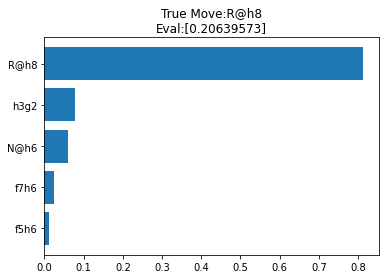

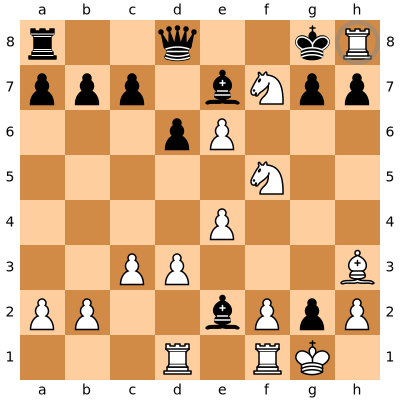

https://lichess.org/aGh9J93k
white's turn
black/white [CrazyhousePocket('qbp'), CrazyhousePocket('rbbbnnn')]


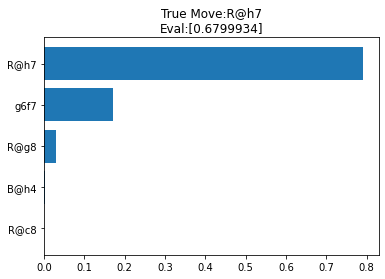

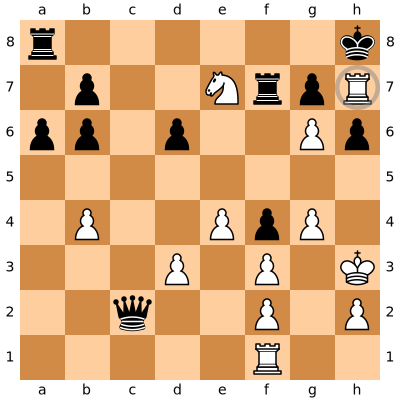

https://lichess.org/N65IVIw4
black's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('bbbnnpppp')]


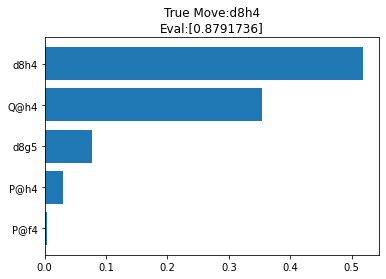

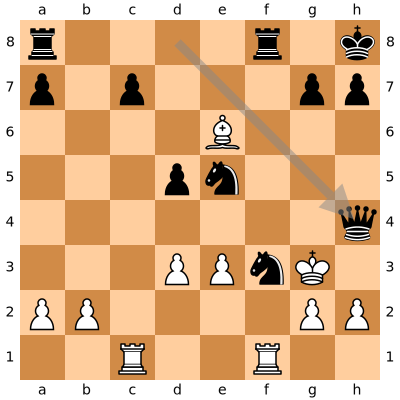

https://lichess.org/zr1Y3Yk0
black's turn
black/white [CrazyhousePocket('npp'), CrazyhousePocket('rbbnnp')]


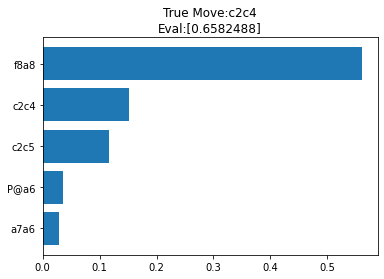

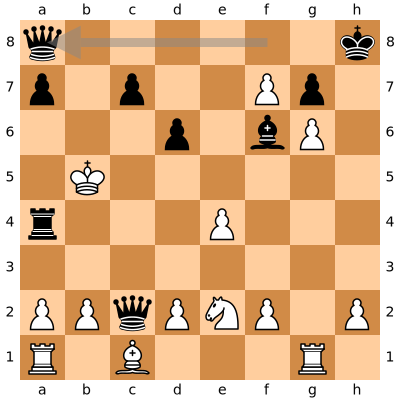

https://lichess.org/BcOhX1Tf
black's turn
black/white [CrazyhousePocket('pp'), CrazyhousePocket('qrrbbbnnpp')]


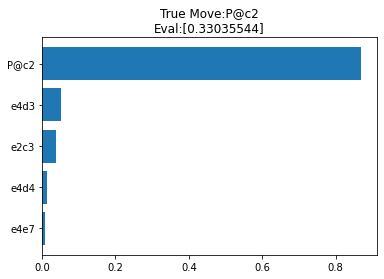

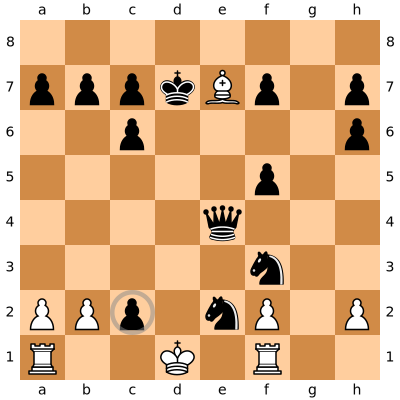

https://lichess.org/NgHPT61x
white's turn
black/white [CrazyhousePocket('qrnppp'), CrazyhousePocket('bnp')]


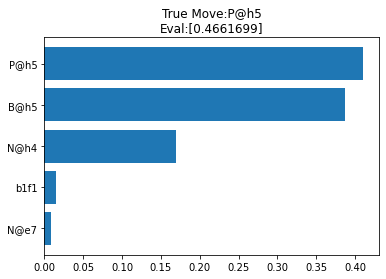

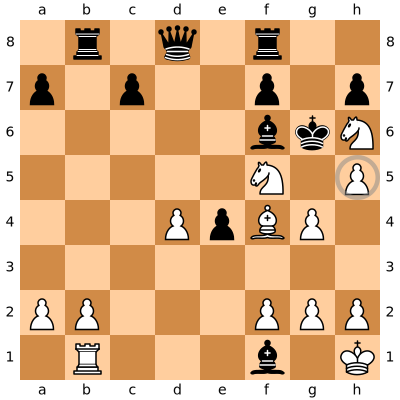

https://lichess.org/JaZSHQvm
black's turn
black/white [CrazyhousePocket('n'), CrazyhousePocket('pppp')]


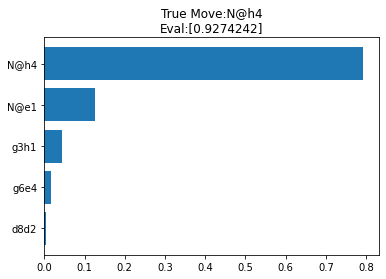

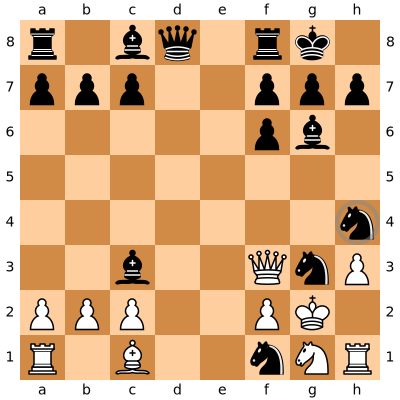

https://lichess.org/aEkH467l
white's turn
black/white [CrazyhousePocket('bpppp'), CrazyhousePocket('r')]


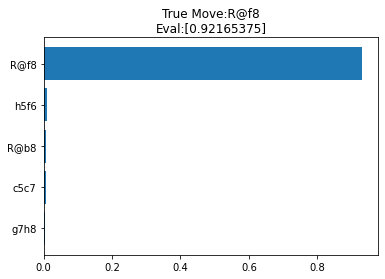

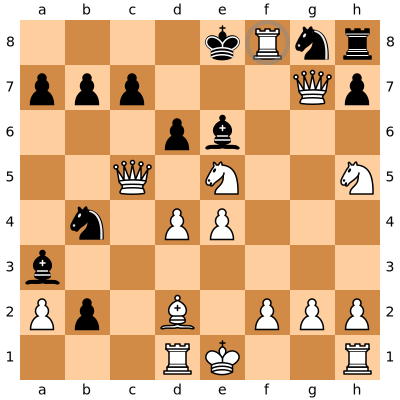

https://lichess.org/AXHqFp0W
white's turn
black/white [CrazyhousePocket('bbbp'), CrazyhousePocket('npp')]


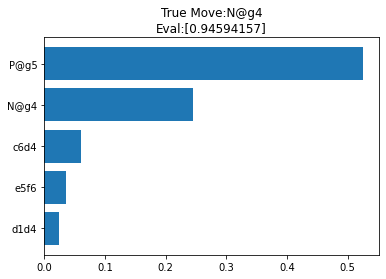

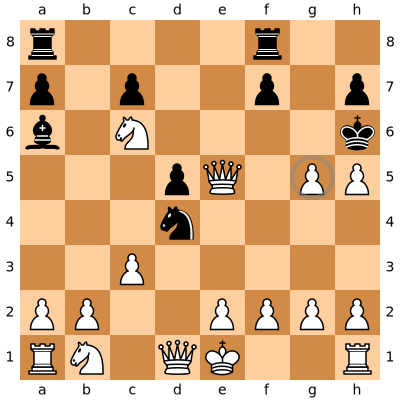

https://lichess.org/koKV9oe5
black's turn
black/white [CrazyhousePocket('p'), CrazyhousePocket('nppp')]


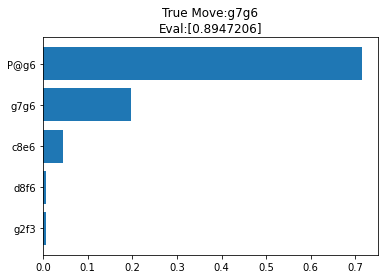

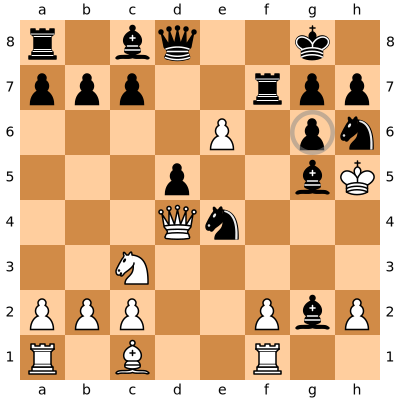

https://lichess.org/l30GAIip
black's turn
black/white [CrazyhousePocket('rbbnpp'), CrazyhousePocket('rp')]


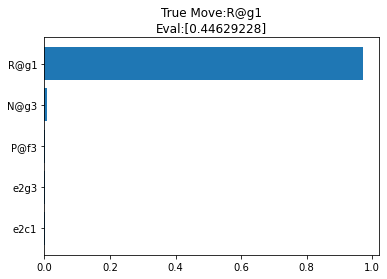

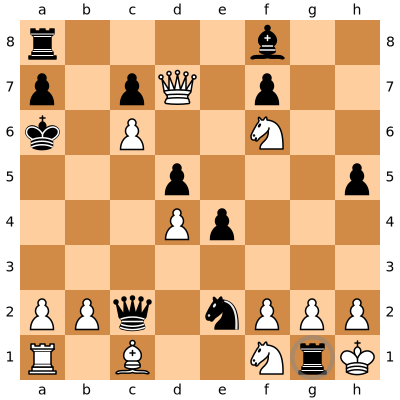

https://lichess.org/qSMyFbYs
white's turn
black/white [CrazyhousePocket('qnn'), CrazyhousePocket('bb')]


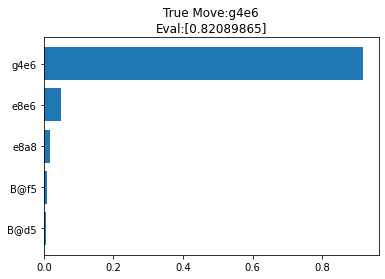

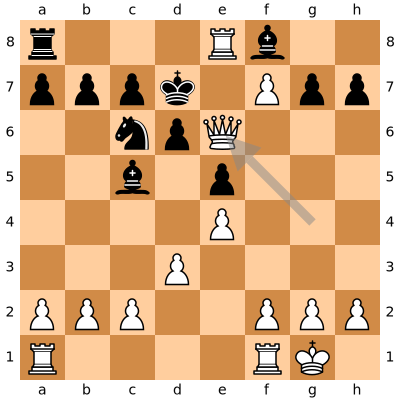

https://lichess.org/CUT8OfGV
white's turn
black/white [CrazyhousePocket('qrbb'), CrazyhousePocket('rnnnpp')]


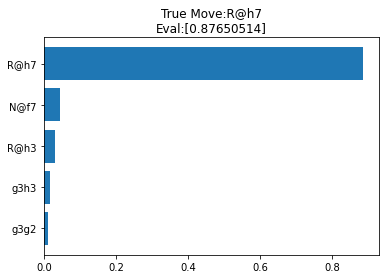

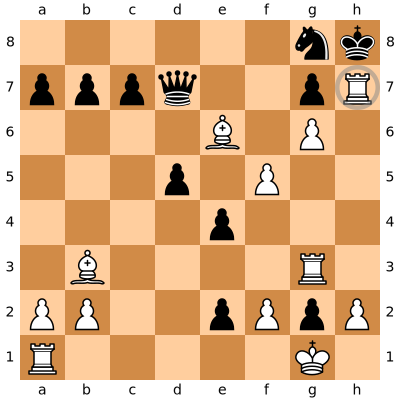

https://lichess.org/N9R4ohE6
black's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('bbbnn')]


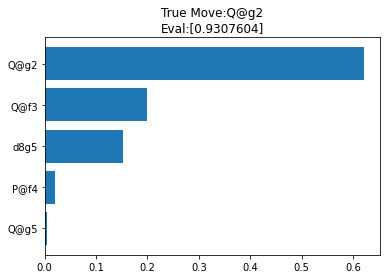

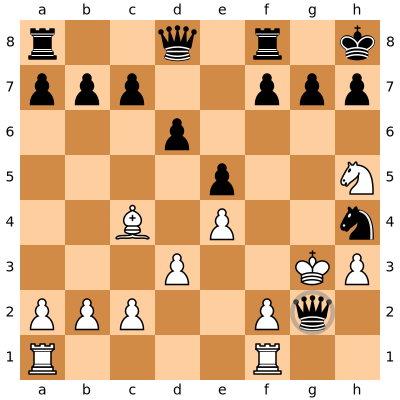

https://lichess.org/uN2inbhr
black's turn
black/white [CrazyhousePocket('q'), CrazyhousePocket('rrppppp')]


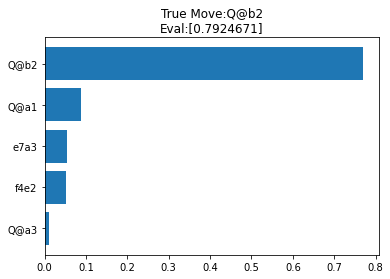

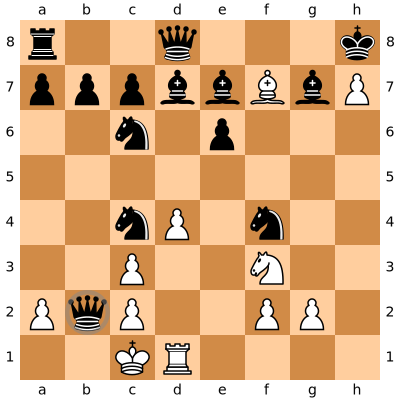

https://lichess.org/N4IMyBUG
black's turn
black/white [CrazyhousePocket('rnppp'), CrazyhousePocket('')]


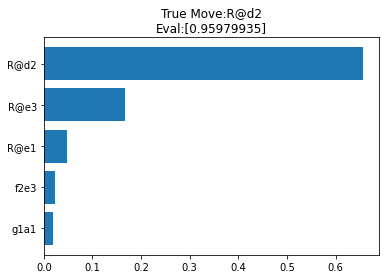

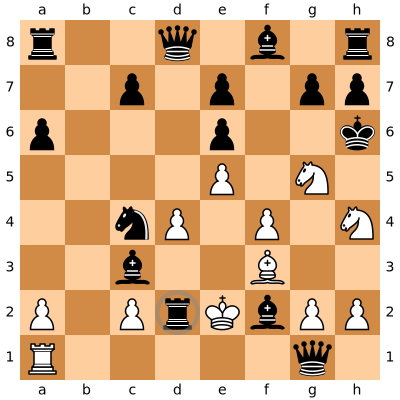

https://lichess.org/wkHxsIKQ
white's turn
black/white [CrazyhousePocket('qbbbnnp'), CrazyhousePocket('rbpp')]


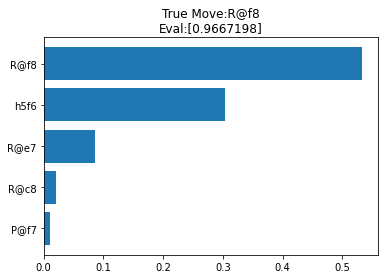

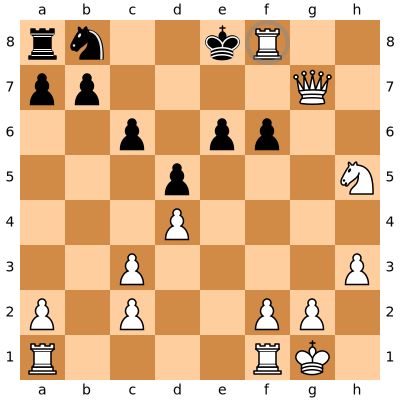

In [65]:
for i in range(17):
    print(clean_string(site_mate[i]))
    pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=True, select_policy_from_plane=tc.select_policy_from_plane)
    pred_move = pred_moves[0]
    pred_arrow = chess.svg.Arrow(pred_move.from_square, pred_move.to_square)
    SVG(data=chess.svg.board(board=board, arrows=[pred_arrow], size=400))

## Show examples where it failed

https://lichess.org/LsrFs69R
black's turn
black/white [CrazyhousePocket('pp'), CrazyhousePocket('qrrbnnpppp')]


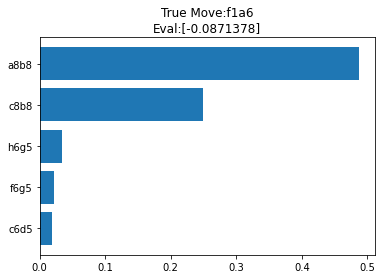

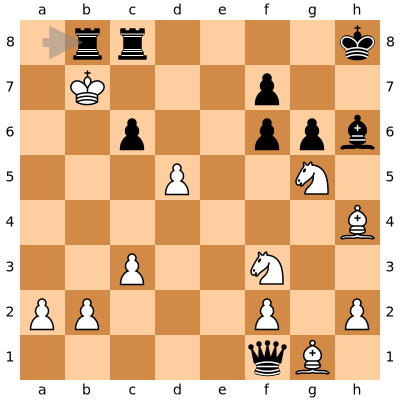

https://lichess.org/Agj9GlEo
white's turn
black/white [CrazyhousePocket('nnpppp'), CrazyhousePocket('p')]


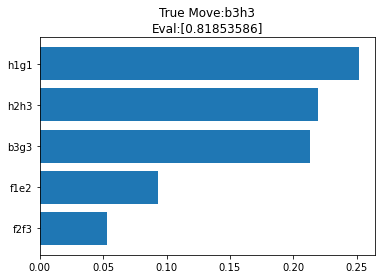

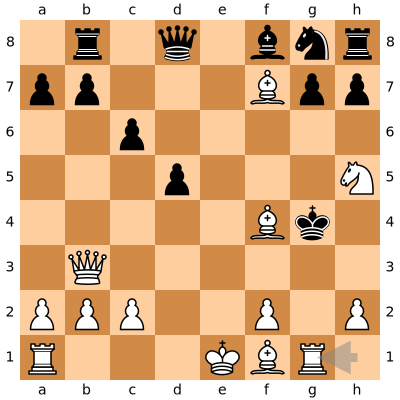

https://lichess.org/DOgF5Y2H
black's turn
black/white [CrazyhousePocket('qbnnnp'), CrazyhousePocket('bp')]


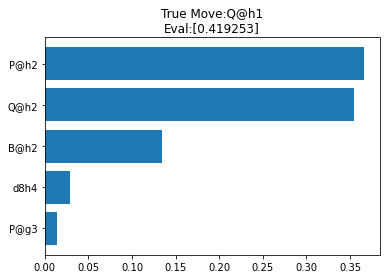

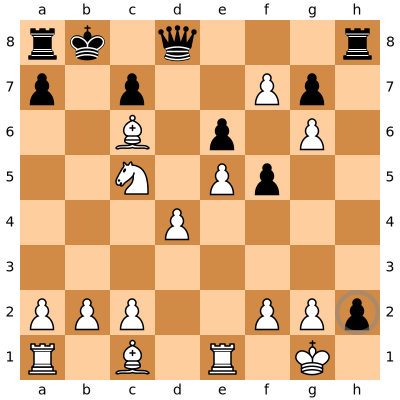

https://lichess.org/5mcYjBhV
white's turn
black/white [CrazyhousePocket('qn'), CrazyhousePocket('p')]


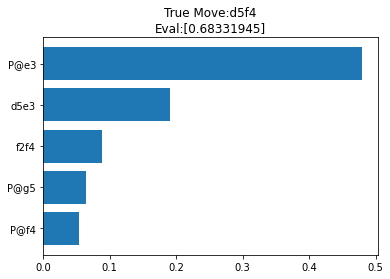

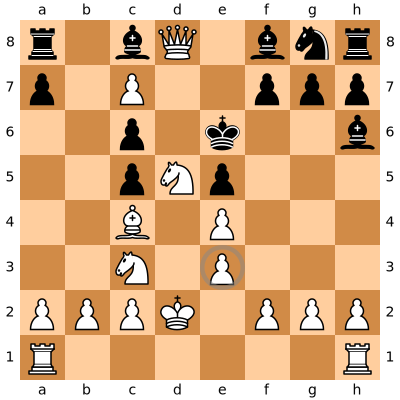

https://lichess.org/3s6SaZ1r
black's turn
black/white [CrazyhousePocket('qrp'), CrazyhousePocket('p')]


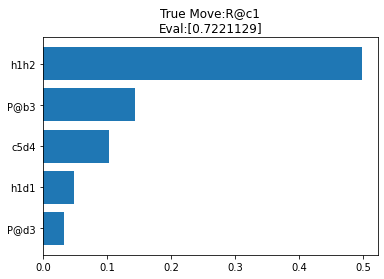

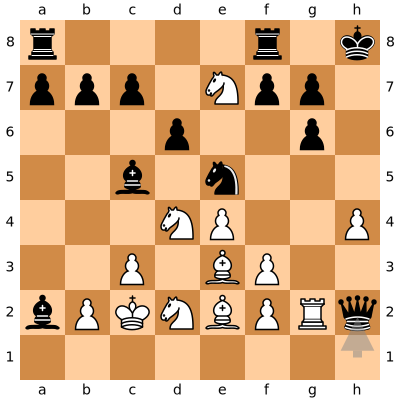

https://lichess.org/5UKVYvyP
white's turn
black/white [CrazyhousePocket('qqrrn'), CrazyhousePocket('bbppp')]


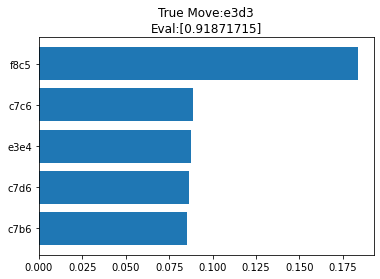

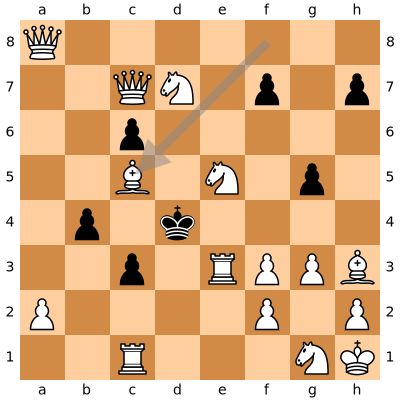

https://lichess.org/nj2PMU8n
white's turn
black/white [CrazyhousePocket('bbnpp'), CrazyhousePocket('pp')]


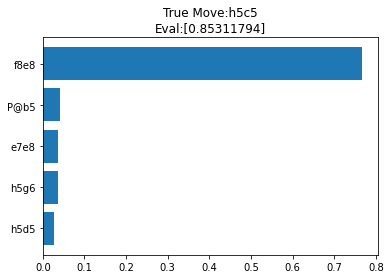

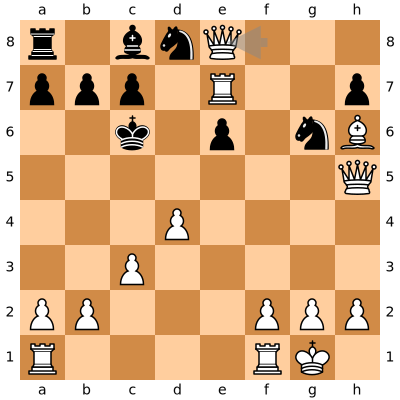

https://lichess.org/eWJbk3pW
black's turn
black/white [CrazyhousePocket('np'), CrazyhousePocket('qnnpp')]


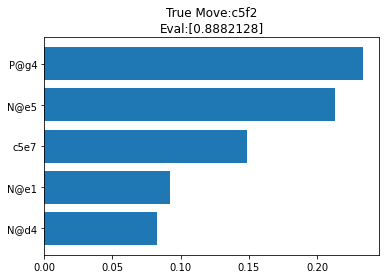

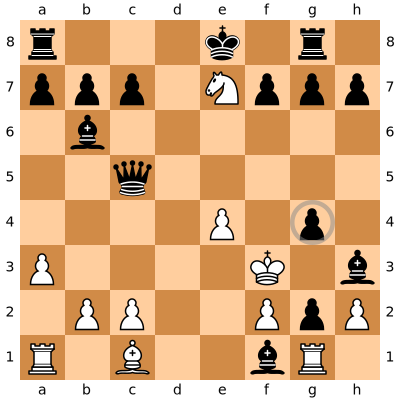

https://lichess.org/UuaM8xP3
white's turn
black/white [CrazyhousePocket('nn'), CrazyhousePocket('q')]


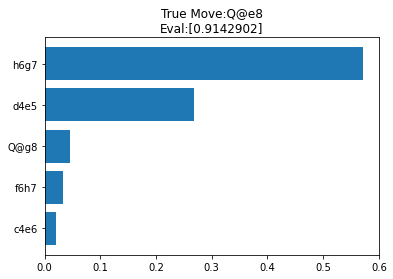

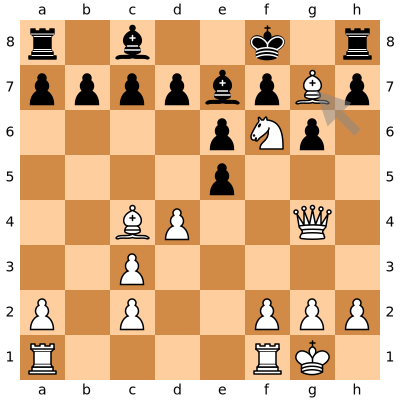

https://lichess.org/en0t9Lcm
black's turn
black/white [CrazyhousePocket('n'), CrazyhousePocket('pp')]


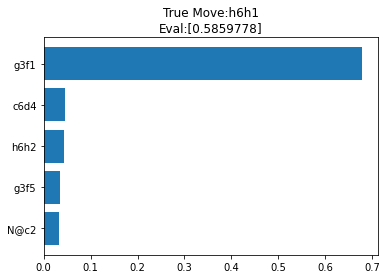

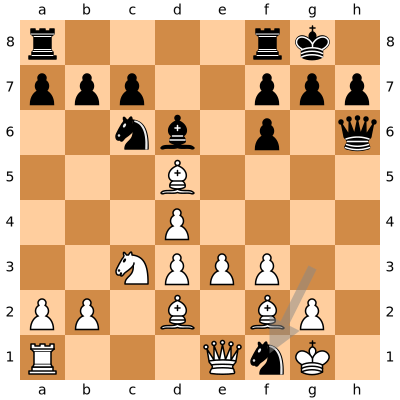

https://lichess.org/Cw8B1A2R
black's turn
black/white [CrazyhousePocket('p'), CrazyhousePocket('rppp')]


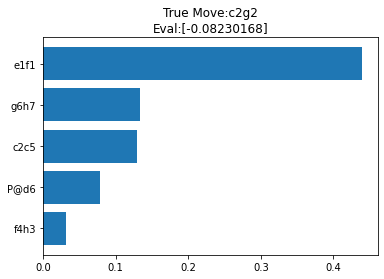

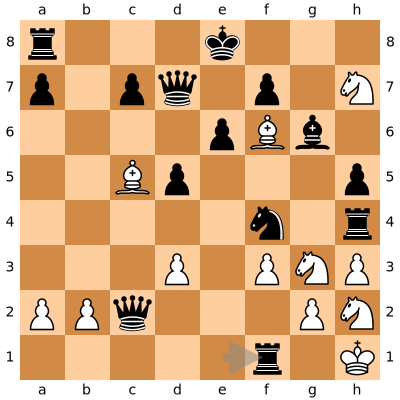

In [66]:
mate_missed = 0
for i in range(1000):
    pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=False, select_policy_from_plane=tc.select_policy_from_plane)
    if is_mate_5_top is False:
        mate_missed += 1
        print(clean_string(site_mate[i]))
        pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=True, select_policy_from_plane=tc.select_policy_from_plane)
        pred_move = pred_moves[0]
        pred_arrow = chess.svg.Arrow(pred_move.from_square, pred_move.to_square)
        SVG(data=chess.svg.board(board=board, arrows=[pred_arrow], size=400))
    if mate_missed == 15:
        break